In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import os

# Load dataset
file_path = os.path.join(os.path.dirname(os.getcwd()), "dataset", "vgsales.csv")
df = pd.read_csv(file_path)

# Filter data up to 2016
df = df[df['Year'] <= 2016]

# Selecting relevant columns for clustering
sales_data = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]
scaler = StandardScaler()
sales_scaled = scaler.fit_transform(sales_data)

# Function to calculate Sessa Empirical Estimator using DBSCAN
def sessa_estimator_dbscan(data, eps_values, min_samples=5):
    ratios = []
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data)
        unique_labels = set(labels)
        if len(unique_labels) > 1 and -1 in unique_labels:
            unique_labels.remove(-1)  # Remove noise cluster
        if len(unique_labels) > 1:
            within_cluster_var = np.sum([np.var(data[labels == label]) for label in unique_labels])
            between_cluster_var = np.sum((np.mean(data, axis=0) - np.mean(data[labels != -1], axis=0)) ** 2)
            ratios.append(between_cluster_var / within_cluster_var if within_cluster_var != 0 else np.nan)
        else:
            ratios.append(np.nan)
    return ratios

# Determine optimal epsilon using Sessa Estimator
eps_values = np.linspace(0.1, 5, 20)
sessa_ratios = sessa_estimator_dbscan(sales_scaled, eps_values)
optimal_eps = eps_values[np.nanargmax(sessa_ratios)]
print(f"Optimal epsilon using Sessa Estimator: {optimal_eps}")

# Apply DBSCAN with optimal epsilon
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
df['Cluster'] = dbscan.fit_predict(sales_scaled)

# Validate clusters (excluding noise)
if len(set(df['Cluster'])) > 1:
    silhouette_avg = silhouette_score(sales_scaled[df['Cluster'] != -1], df['Cluster'][df['Cluster'] != -1])
    print(f"Silhouette Score for optimal epsilon: {silhouette_avg:.2f}")

# Analyze cluster characteristics
cluster_means = df.groupby('Cluster')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].mean()

# Assigning meaningful labels based on sales trends
cluster_labels = {-1: "Noise"}
avg_sales = cluster_means['Global_Sales'].sort_values()
for i, cluster_id in enumerate(avg_sales.index):
    if cluster_id == -1:
        continue
    if i == 0:
        cluster_labels[cluster_id] = "Low Sales"
    elif i == 1:
        cluster_labels[cluster_id] = "Moderate Sales"
    elif i == 2:
        cluster_labels[cluster_id] = "High Sales"
    else:
        cluster_labels[cluster_id] = "Blockbuster Hits"
df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

Optimal epsilon using Sessa Estimator: 0.1
Silhouette Score for optimal epsilon: 0.29


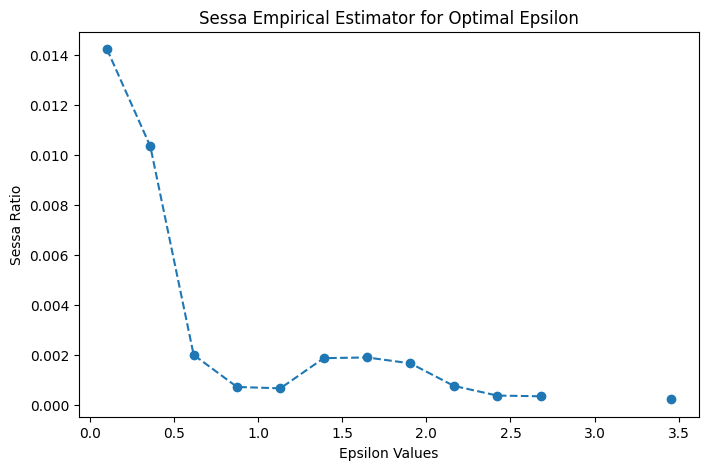

In [4]:
# Plot Sessa Ratios
plt.figure(figsize=(8, 5))
plt.plot(eps_values, sessa_ratios, marker='o', linestyle='--')
plt.xlabel('Epsilon Values')
plt.ylabel('Sessa Ratio')
plt.title('Sessa Empirical Estimator for Optimal Epsilon')
plt.show()

This line plot visualizes the Sessa Ratio for different values of *epsilon (eps)*, which is a key parameter in DBSCAN clustering.

- The X-axis represents different *epsilon values* tested

- The Y-axis represents the Sessa Ratio, which is used to evaluate clustering performance.

- The point with the highest ratio is the optimal *eps* value, meaning it gives the best seperation between clusters.

**DBSCAN** requires tuning of the *eps* value to correctly detect meaningful clusters.

- The **Sessa Empirical Estimator** helps find the optimal *eps* by balancing within-cluster variance (tightness) and between-cluster variance (seperation).

- The peak of the curve suggests the best *eps* to use, leading to well-defined clusters with minimal noise.

### **Key Insights** ###
- A higher Sessa Ratio means better-defined clusters.

- The chosen *eps* value (where the ratio peaks) is used in the next step for **DBSCAN** clustering.

- If the Sessa Ratio is low across all values, it might indicate that the data is not naturally clustered or that a different clustering method is needed.

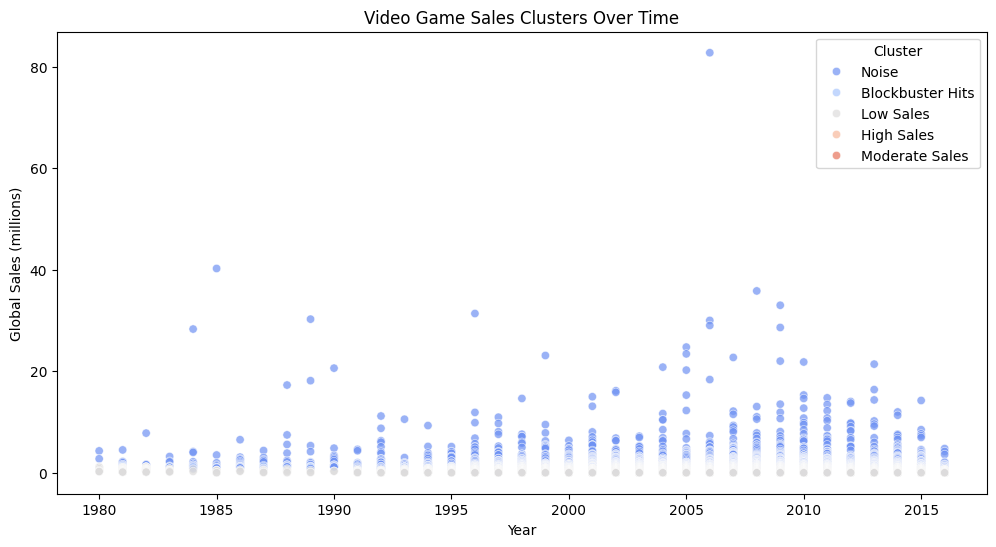

In [5]:
# Visualization of clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['Year'], y=df['Global_Sales'], hue=df['Cluster_Label'], palette='coolwarm', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Global Sales (millions)')
plt.title('Video Game Sales Clusters Over Time')
plt.legend(title='Cluster')
plt.show()

This is a scatter plot of video game sales across different years, colored by cluster labels.

- The X-axis represents the *Year* (when the game was released).

- The Y-axis represents *Global Sales* (in millions).

Each point represents a game, and its color indicates its assigned cluster:

- Low sales
- Moderate Sales
- High Sales
- Blockbuster Hits
- Noise (-1, meaning DBSCAN didn't classify it into a meaningful group)

This is to show how video game sales evolved over time. It identifies trends in high-selling games and which years had more top-selling titles. It detects *outliers* (noise), which may be anomalies or niche releases.

### **Key Insights** ###

- Some years had spikes in blockbuster games, meaning certain periods saw major industry hits.

- The presence of noise indicates games with unique sales patterns that don't fit the typical clusters.

- Older games tend to have lower global sales (partially due to limited ditribution back then), whereas modern games can reach global audiences more easily.

- Block buster titles are often concentrated in specific years, suggesting trends in gaming industry success.

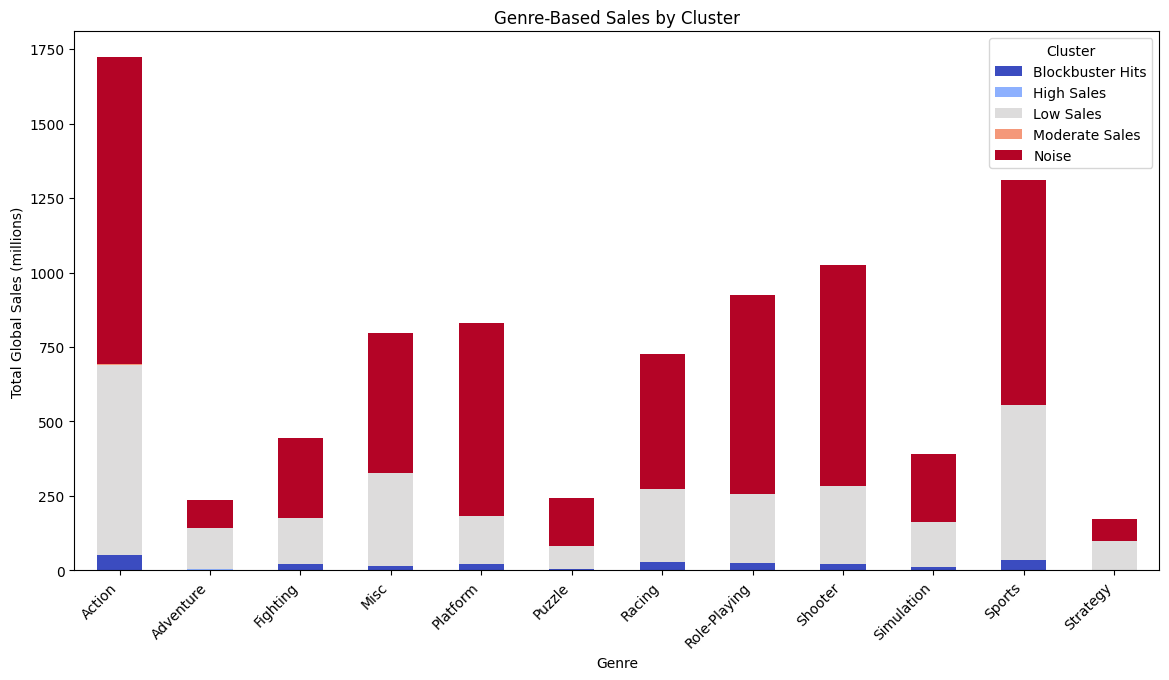

In [6]:
# Genre-based Clustering Visualization
genre_sales = df.groupby(['Genre', 'Cluster_Label'])['Global_Sales'].sum().unstack()
genre_sales.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='coolwarm')
plt.xlabel('Genre')
plt.ylabel('Total Global Sales (millions)')
plt.title('Genre-Based Sales by Cluster')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster')
plt.show()

This stacked bar chart shows total sales per genre, grouped by there assigned sales cluster.

- The X-axis represents different video game genres (e.g., Sports, RPG, Action, etc.).

- The Y-axis represents total global sales (in millions).

Each stacked color represents a sale cluster:

- Low Sales (bottom section)
- Moderate Sales
- High Sales
- Blockbuster Hits (top section)

This is to see which genre dominate each sales category. By identifying sales distribution patterns across different types of games we can understanding wheter certain genres are more likely to become blockbuster hits or remain in lower sales tiers. 

### **Key Insights** ###

- Some genres have more Blockbuster Hits, meaning they have historically produced many top-selling games.

- RPG and Strategy games have a mix of sales clusters, showing that some become huge hits, but many remain mid-tier in sales.

- Certain genres like *Puzzle and Adventure*, mostly fall in *Low Sales* or *Moderate Sales* categories, indicating a niche market with fewer global bestsellers.

- The stacking effect highlights how sales distribution vary some genres consistently sell well, while others depend on occasional big hits.

### **Final Insights** ###

In [7]:
# Generate insights
print(f"Total number of games analyzed: {df.shape[0]}")

Total number of games analyzed: 16323


- Clusters represent different levels of commercial success, from low sales to blockbuster hits, with DBSCAN identifying outlier patterns.

- Certain genres dominate the Blockbuster Hits cluster, while others are more evenly distributed across categories.

- Sales trends indicate fluctuations in top-performing genres over time, and DBSCAN reveals additional insights about noise and anomalies.